# Nearest neighbour analysis

The idea of neighbourhood is one of the fundamental concepts in geographic data analysis and modelling. Being able to understand how close geographic objects are to each other, or which features are neighboring a specific location is fundamental to various spatial analysis techniques, such as spatial interpolation (which we cover in Chapter 10) or understanding whether there exist spatial autocorrelation (i.e. clustering) in the data (see Chapters [6](https://geographicdata.science/book/notebooks/06_spatial_autocorrelation.html) and [7](https://geographicdata.science/book/notebooks/07_local_autocorrelation.html) in {cite}`Rey_et_al_2023`). Many of these techniques rely on the idea that proximity in geographic space typically indicates also similarity in attribute space. For example, it is quite typical that a neighborhood with high population density is next to another neighborhood that also has high concentration of residents (i.e. the population density tend to cluster). One of the most famous notions related to this is the *First law of geography* which states that "everything is related to everything, but near things are more related than distant things" ({cite}`Tobler1970`). Thus, being able to understand how close neighboring geographic features are, or which objects are the closest ones to specific location is an important task in GIS. 

**Figure 6.43** illustrates two common ways to find nearest neighbors to specific locations. In these examples, we have two Point datasets visualized with blue circles and red rectangles that are used for doing the nearest neighbor analysis. In the first example (top row), the idea is to find the closest geometry (rectangles) for all the points in the area. Here, the nearest neighbor is determined based on distance between the points and rectangles, and the nearest neighbors are visualized with a line from every point to the closest rectangle (on the right). The bottom row shows an example in which we aim to find the closest point for each rectangle, but in this case we also apply a maximum search distance that limits the search area. Only those points that are within the search area are considered when finding the nearest neighbor, while the points outside of this area are simply ignored. As a result, the point closest to a given rectangle is visualized with a connected line (on the right). In these examples, the geographic objects are simple point like features, but similar approach can be used with any geographic features, for example by finding closest LineString or Polygon geometry to a given Point, or by finding the closest Polygon to another Polygon. In these cases, the calculations are a bit more complicated, but the basic idea is the same. 

![_**Figure 6.43**. The basic idea of finding a nearest neighbour based on geographic distance.](../img/nearest-neighbour.png)

_**Figure 6.43**. The basic idea of finding a nearest neighbour based on geographic distance._

Quite often with very large datasets, we might want to limit the search area up to a specific maximum distance. This can be due to practical reasons as it can significantly speed up the computation time, or because we have specific reasoning that makes it sensible to limit the search area. For example, if we would aim to understand how easily accessible public transportation is to citizens living in a city, it would make sense to limit the search area e.g. up to 2 km from the homes of people, because people are not willing to walk for very long distances to get into a bus stop. It's important to notice that the distances in the calculations are commonly based on the Euclidian distance, i.e. we calculate the distances based on coordinates on a Cartesian plain, meaning that the distances do not consider changes in height (i.e. third dimension is omitted). It is of course possible also to consider 3D distances, but the most typical Python tools ignore the height information. 

## Nearest neighbour analysis in Python

In Python, there are various libraries that can be used to find nearest neighbors for given set of geometries, including `geopandas`, `shapely`, `scipy`, `scikit-learn`, and `pysal` among others. Here, we first introduce how `geopandas` can be used to find the nearest neighbors for all Point geometries in a given GeoDataFrame based on Points in another GeoDataFrame. Then we show how to find nearest neighbor between two Polygon datasets, and finally we show how to use `scipy` library to find K-Nearest Neighbors (KNN) with Point data.

In the following, we go through a very practical example that relates to our daily commute: Where is the closest public transport stop from my place of living? Hence, our aim is to search for each building point in the Helsinki Region the closest public transport stop. In geopandas, we can find nearest neighbors for all geometries in a given GeoDataFrame very easily by using a method called `.sjoin_nearest()`. To show how to use this method, let's start by reading two datasets representing buildings and stops into GeoDataFrames, and visualize them to understand a bit better what we have:

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

stops = gpd.read_file("data/Helsinki/pt_stops_helsinki.gpkg")
building_points = gpd.read_file("data/Helsinki/building_points_helsinki.zip")

print("Number of stops:", len(stops))
stops.head(2)

Number of stops: 8377


stop_name  stop_lat  stop_lon  stop_id                   geometry
0  Ritarihuone  60.16946  24.95667  1010102  POINT (24.95667 60.16946)
1   Kirkkokatu  60.17127  24.95657  1010103  POINT (24.95657 60.17127)

In [2]:
print("Number of buildings:", len(building_points))
building_points.head(2)

Number of buildings: 158731


name                   geometry
0         None  POINT (24.85584 60.20727)
1  Uimastadion  POINT (24.93045 60.18882)

As we can see, both GeoDataFrames contain Point geometries. There seems to be approximately 8400 stops and almost 159 thousand buildings in our data. Hence, we have already a fair amount of data and calculations to do, to find the nearest neighbor for each building. Let's still visualize the GeoDataFrames next to each other so that we can see them on a map:

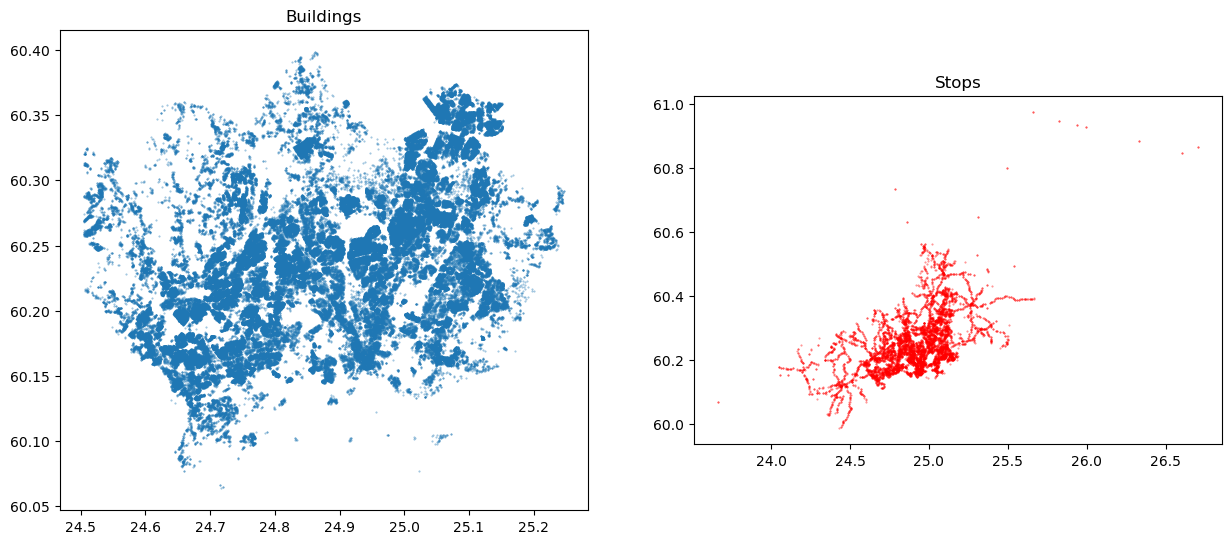

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

# Plot buildings
building_points.plot(ax=ax1, markersize=0.2, alpha=0.5)
ax1.set_title("Buildings")

# Plot stops
stops.plot(ax=ax2, markersize=0.2, alpha=0.5, color="red")
ax2.set_title("Stops");

_**Figure 6.44**. Maps representing the buildings and public transport stops which we use to find the closest stop for each building._

As mentioned earlier, finding the nearest geometries between two GeoDataFrames (here building and stop points) can be done easily using the `.sjoin_nearest()` method in geopandas. As the name implies, this method is actually designed to merge data between GeoDataFrames in a similar manner as with regular `.sjoin()` method that we saw earlier in Chapter 6.7. However, in this case the method is actually searching for the closest geometries instead of relying on spatial predicates, such as *within*. The `sjoin_nearest()` can be used for different geometry types, so the input geometries do not necessarily need to be Point objects as in our example. Under the hood, the method uses a *{term}`spatial index`* called `STRTree` ({cite}`leutenegger_1997`) which is an efficient implementation of the *{term}`R-tree`* dynamic index structure for spatial searching ({cite}`guttman_1984`). The STRTree is implemented in the `shapely` library (used by geopandas) and the technique makes the nearest neighbor queries very efficient. You can read more about spatial indices in Appendices section of the book. For the method to work properly, it is recommended to ensure that the both GeoDataFrames are having the same coordinate reference system (CRS), and preferably having a projected (metric) CRS because that ensures that the reported distances are meaningful (in meters) and correct. Hence, let's start by reprojecting our latitude and longitude values into a metric system using the national EUREF-FIN coordinate reference system (EPSG code 3067) for Finland:

In [4]:
stops = stops.to_crs(epsg=3067)
building_points = building_points.to_crs(epsg=3067)

stops.head(2)

stop_name  stop_lat  stop_lon  stop_id                        geometry
0  Ritarihuone  60.16946  24.95667  1010102  POINT (386623.301 6672037.884)
1   Kirkkokatu  60.17127  24.95657  1010103  POINT (386623.991 6672239.572)

Now the GeoDataFrames are surely in the same coordinate system and we can see that the coordinates in the `geometry` column have changed representing meters. Next, we will use the `buildings.sjoin_nearest()` to find the closest stop for each building. Because we are interested to find the closest stop geometry for each building, the `buildings` GeoDataFrame is the left hand side of the command. As inputs, we pass the `stops` GeoDataFrame as well as give a name for a column which is used to store information about the distance between a given building and the closest stop (this is optional):

In [5]:
%time
closest = building_points.sjoin_nearest(stops, distance_col="distance")
closest

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.15 µs


name                        geometry  index_right  \
0                     None  POINT (381166.600 6676424.438)         1131   
1              Uimastadion  POINT (385236.565 6674238.472)          467   
2                     None  POINT (386317.478 6672100.648)           61   
3           Hartwall Arena  POINT (385225.109 6676120.560)          532   
4                    Talli  POINT (385079.733 6676989.745)          496   
...                    ...                             ...          ...   
158726                None  POINT (373896.051 6677472.204)         4621   
158727                None  POINT (372425.650 6676945.528)         4654   
158728                None  POINT (374696.625 6677972.738)         4655   
158729     Granhultsskolan  POINT (373287.582 6677731.639)         4624   
158730  Kauniaisten kirkko  POINT (374112.695 6677330.017)         4665   

                stop_name  stop_lat   stop_lon  stop_id    distance  
0              Muusantori  60.20749  24.857450  1304138   92.679893  
1        Auroran sairaala  60.19145  24.925540  1171122  400.243370  
2            Senaatintori  60.16901  24.950460  1020450  109.819633  
3               Veturitie  60.20661  24.929680  1174112  104.632434  
4                 Posti 1  60.21345  24.917550  1172143  472.248282  
...                   ...       ...        ...      ...         ...  
158726              Samis  60.21369  24.720970  3170209  195.675552  
158727  Yrjö Liipolan tie  60.20922  24.695470  3170244  137.137640  
158728     Kandidaatintie  60.21818  24.736987  3170245  135.341745  
158729          Uimahalli  60.21638  24.711260  3170212   99.408108  
158730          Postitori  60.21267  24.728250  3170257   67.790422  

[159818 rows x 8 columns]

As a result, we now have found the closest stop for each building including the attributes of the closest stops that were merged into the results. The last column in the table shows the distance in meters between a given building and the closest stop. The distance is only returned upon request as we did by specifying `distance_col="distance"`. The column `index_right` provides information about the index number of the closest stop in the `stops` GeoDataFrame. If you look carefully, you can see that the number of rows in our result has actually increased slightly from the original (158731 vs 159818). This happens because for some geometries in the `buildings` GeoDataFrame, the distance between the building and two (or more) stops have been exactly the same (i.e. they are equidistant). In such cases, the `sjoin_nearest()` will store both records into the results by duplicating the building information and attaching information from the stops into separate rows accordingly. In some cases, this can cause trouble for further analysis, so it is good to be careful and investigate whether any duplicate buildings have emerged into the results. If they have emerged, and if this causes issues in your analysis, you might need to pick one of them based on some criteria. Alternatively, you can just pick the first (or last) one if you do not have any specific justification for making the selection.

The `%time` command at the beginning of the cell provides us some details about the time it took to find the nearest neighbors and merge the data between the two GeoDataFrames. As we can see, the computations are very efficient taking only a matter of some microseconds for almost 159 thousand observations. We can make this even faster by specifying a `max_distance` parameter that specifies the maximum search distance. Here, we specify the maximum distance as 100 meters from each building:

In [6]:
%time
closest_limited = building_points.sjoin_nearest(stops, max_distance=100, distance_col="distance")
closest_limited

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 1.91 µs


name                        geometry  index_right  \
0                     None  POINT (381166.600 6676424.438)         1131   
10                    None  POINT (384645.078 6669763.917)          592   
12                    None  POINT (384782.782 6669707.017)          595   
13                    None  POINT (384714.470 6669710.887)          592   
16                    None  POINT (385040.806 6670639.517)          596   
...                    ...                             ...          ...   
158718                None  POINT (374219.973 6677006.100)         4651   
158719                None  POINT (374231.494 6676967.402)         4642   
158720                None  POINT (374602.815 6677396.180)         4673   
158729     Granhultsskolan  POINT (373287.582 6677731.639)         4624   
158730  Kauniaisten kirkko  POINT (374112.695 6677330.017)         4665   

                  stop_name   stop_lat   stop_lon  stop_id   distance  
0                Muusantori  60.207490  24.857450  1304138  92.679893  
10      Hernesaaren laituri  60.148287  24.923281  1204101  57.786201  
12      Hernesaaren laituri  60.148680  24.924240  1204108  79.844881  
13      Hernesaaren laituri  60.148287  24.923281  1204101  32.640335  
16          Hernesaarenkatu  60.156110  24.930370  1204109  87.888087  
...                     ...        ...        ...      ...        ...  
158718    Kauniaisten asema  60.210830  24.729330  3170240  69.803673  
158719       Kauniaistentie  60.209810  24.731510  3170230  63.384115  
158720       Raamattuopisto  60.213524  24.736685  3170265  56.594370  
158729            Uimahalli  60.216380  24.711260  3170212  99.408108  
158730            Postitori  60.212670  24.728250  3170257  67.790422  

[40128 rows x 8 columns]

As we can see, there was a slight improvement in the execution time compared to the previous call without specifying the `max_distance` parameter. The difference can be more significant if you have larger datasets or more complicated geometries (e.g. Polygons). One important aspect to notice from these results is that the number of rows has decreased significantly: from 160 to 40 thousand buildings. This happens because our search distance was very low (100 meters), and as a consequence, there were many buildings that did not have any stops within 100 meter radius from them. Because the default join type in `sjoin_nearest` is `inner` join, all the records that did not have a stop within 100 meters were dropped. If you would like to keep all the records in the results, to e.g. investigate which buildings do not have any stops within the search radius, you can add parameter `how="left"`, which will retain all buildings from the original GeoDataFrame.

In some cases, you might actually want to connect the nearest neighbors to each other with a straight line. For doing this, we need to merge also the Point geometries from the other layer into our results, which can then be used to create a LineString connecting the points to each other. This can be useful for many purposes, but in our case, we want to do this to be able to validate whether our results are correct. For merging the closest stop geometries into our results, we can take advantage of the `index_right` column in our table and conduct a normal table join using the `.merge()` method. Below, we first store the index of the `stops` GeoDataFrame into a column called `stop_index` and then use this to make a table join with our `closest` GeoDataFrame. Notice that we only keep the `stop_index` and `geometry` columns from the `stops` GeoDataFrame because all the other attributes already exist in our results: 

In [7]:
stops["stop_index"] = stops.index
closest = closest.merge(stops[["stop_index", "geometry"]], left_on="index_right", right_on="stop_index")
closest.head()

name                      geometry_x  index_right  \
0            None  POINT (381166.600 6676424.438)         1131   
1     Uimastadion  POINT (385236.565 6674238.472)          467   
2            None  POINT (386317.478 6672100.648)           61   
3  Hartwall Arena  POINT (385225.109 6676120.560)          532   
4           Talli  POINT (385079.733 6676989.745)          496   

          stop_name  stop_lat  stop_lon  stop_id    distance  stop_index  \
0        Muusantori  60.20749  24.85745  1304138   92.679893        1131   
1  Auroran sairaala  60.19145  24.92554  1171122  400.243370         467   
2      Senaatintori  60.16901  24.95046  1020450  109.819633          61   
3         Veturitie  60.20661  24.92968  1174112  104.632434         532   
4           Posti 1  60.21345  24.91755  1172143  472.248282         496   

                       geometry_y  
0  POINT (381256.660 6676446.317)  
1  POINT (384973.331 6674539.973)  
2  POINT (386277.250 6671998.462)  
3  POINT (385255.784 6676220.595)  
4  POINT (384607.679 6677003.267)

As a result, we now brought two new columns into our results, namely `stop_index` and `geometry_y`. Because there was a column called `geometry` in both GeoDataFrames, geopandas automatically renamed the columns into `geometry_x` and `geometry_y` respectively. Now we have all the data that we need to create a connecting `LineString` between the buildings and the closest stops. We can do this by looping over the rows in our `closest` GeoDataFrame using the `.apply()` method (see Chapter 3.3 for more details) and then create the line by calling the shapely's `LineString` object which takes the Point geometries as input. We store these LineStrings into a column `geometry` which we lastly set to be the active geometry of the GeoDataFrame:    

In [8]:
from shapely import LineString
closest["geometry"] = closest.apply(lambda row: LineString([row["geometry_x"], row["geometry_y"]]), axis=1)
closest = closest.set_geometry("geometry")
closest.head()

name                      geometry_x  index_right  \
0            None  POINT (381166.600 6676424.438)         1131   
1     Uimastadion  POINT (385236.565 6674238.472)          467   
2            None  POINT (386317.478 6672100.648)           61   
3  Hartwall Arena  POINT (385225.109 6676120.560)          532   
4           Talli  POINT (385079.733 6676989.745)          496   

          stop_name  stop_lat  stop_lon  stop_id    distance  stop_index  \
0        Muusantori  60.20749  24.85745  1304138   92.679893        1131   
1  Auroran sairaala  60.19145  24.92554  1171122  400.243370         467   
2      Senaatintori  60.16901  24.95046  1020450  109.819633          61   
3         Veturitie  60.20661  24.92968  1174112  104.632434         532   
4           Posti 1  60.21345  24.91755  1172143  472.248282         496   

                       geometry_y  \
0  POINT (381256.660 6676446.317)   
1  POINT (384973.331 6674539.973)   
2  POINT (386277.250 6671998.462)   
3  POINT (385255.784 6676220.595)   
4  POINT (384607.679 6677003.267)   

                                            geometry  
0  LINESTRING (381166.600 6676424.438, 381256.660...  
1  LINESTRING (385236.565 6674238.472, 384973.331...  
2  LINESTRING (386317.478 6672100.648, 386277.250...  
3  LINESTRING (385225.109 6676120.560, 385255.784...  
4  LINESTRING (385079.733 6676989.745, 384607.679...

Great! Now we have created a new geometry column that contains the lines between buildings and the closest stops. To better understand the results, let's create a nice map that visualizes the buildings, stops and the connecting lines between the buildings and the closest stops in a single figure: 

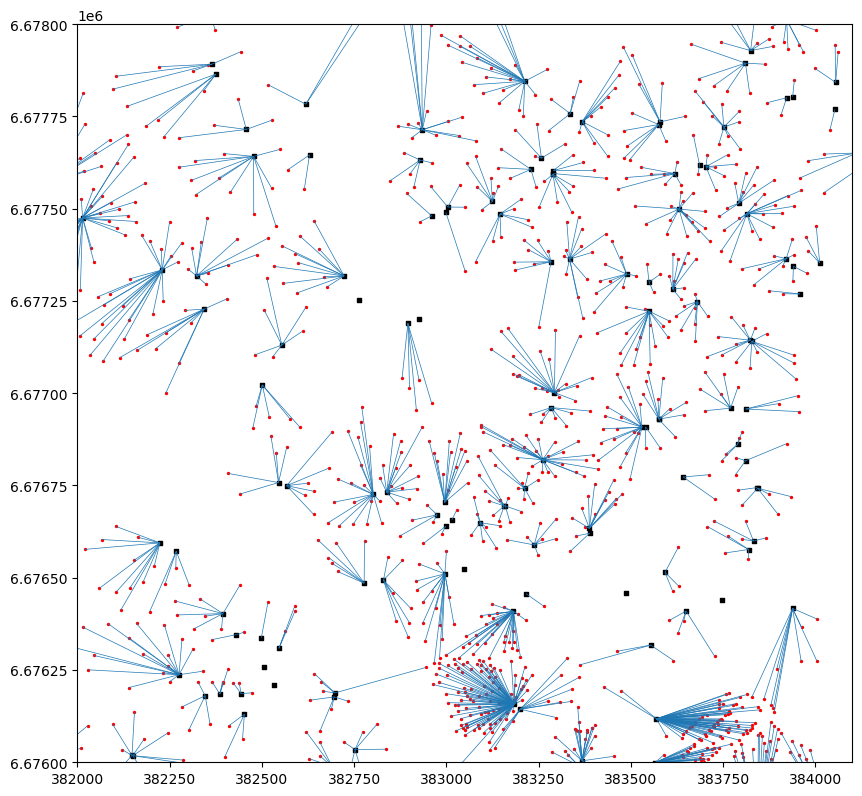

In [9]:
ax = closest.plot(lw=0.5, figsize=(10,10))
ax = building_points.plot(ax=ax, color="red", markersize=2)
ax = stops.plot(ax=ax, color="black", markersize=8.5, marker="s")
# Zoom to specific area
ax.set_xlim(382000, 384100)
ax.set_ylim(6676000, 6678000);

_**Figure 6.45**. A map showing the buildings (red points), the stops (black rectangles) and the lines between the buildings and the closest stops._

As we can see from the Figure 6.45, the nearest neighbor search have worked well as planned, and each building marked with red color has been correctly connected with a line to the closest stop. The map reveals that there are multiple isolated stops that do not have any buildings connected to them. As a practical example, this information could be used e.g. for transport planning by investigating whether these isolated stops are less used by citizens to get on board of the public transport vehicles. This information could again be used by transport planners to decide whether there is a need to maintain these isolated stops. Thus, with these rather simple computations, one can already provide useful information that has relevance in real life. Finally, because we have calculated the distance between buildings and the stops, it is easy to do some descriptive analysis based on this data providing information about levels of access to public transport in the region: 

In [10]:
closest["distance"].describe()

count    159818.000000
mean        229.029606
std         292.348698
min           0.743490
25%          99.771301
50%         163.805853
75%         260.461391
max        7698.270635
Name: distance, dtype: float64

As we can see, the average distance to public transport in the region is around 230 meters. More than 75 % of the buildings seem to be within within 3.5 minute walking time (~260 meters with walking speed of 4.5 kmph) which indicates very good situation in terms of accessibility levels in the region overall. There seem to be some really remote buildings in the data as well, as the longest distance to closest public transport stop is more than 7 kilometers.

### Nearest neighbors with Polygon and LineString data

In some cases, you might need to find the closest neighbors for a given set of Polygons or LineStrings. Luckily, the `sjoin_nearest()` method works in a similar manner with all geometry types, i.e. you can find the nearest neighbors using Point, LineString, Polygon, MultiPoint, MultiLineString and MultiPoint geometries as input. Also finding nearest neighbors between different geometry types is supported, meaning that you can for example search nearest LineStrings to Polygons, and so on. When using more complex geometries as input (e.g. LineStrings or Polygons), the nearest neighbor search uses spatial index, i.e. it creates bounding boxes around the input geometries and inserts them into an R-Tree which is used to make the search queries more efficient. However, the distance between the nearest neighbours is measured based on the true shapes of the geometric features. In the following, we demonstrate how to conduct nearest neighbor analysis with more complex geometries, such as Polygons and LineStrings.

As a real-life case, we first aim to find the closest urban park to building polygons in a neighborhood called Kamppi, which is located in Helsinki, Finland. Then, we aim to find the closest drivable road (LineString) to each building. Let's start by reading the data and visualize it on a map:

In [11]:
import geopandas as gpd

buildings = gpd.read_file("data/Helsinki/Kamppi_buildings.gpkg")
parks = gpd.read_file("data/Helsinki/Kamppi_parks.gpkg")
roads = gpd.read_file("data/Helsinki/Kamppi_roads.gpkg")
buildings

osmid    building                   name  \
0    11711721042         yes  Nice Bike Pyörähuolto   
1        8035238      public            Lasipalatsi   
2        8042297         yes     Radisson Blu Royal   
3       14797170      school                   None   
4       14797171         yes                   None   
..           ...         ...                    ...   
450      8092998         yes                   None   
451      8280536  apartments                   None   
452      8525159       civic                   None   
453      8525161       civic                   None   
454      8535506       civic                   None   

                                              geometry  
0                       POINT (384966.661 6671503.786)  
1    POLYGON ((385459.650 6672184.469, 385456.356 6...  
2    POLYGON ((385104.154 6671916.693, 385101.584 6...  
3    POLYGON ((384815.326 6671762.710, 384815.792 6...  
4    POLYGON ((384797.759 6671853.253, 384798.253 6...  
..                                                 ...  
450  POLYGON ((384747.465 6671811.996, 384744.270 6...  
451  POLYGON ((384839.007 6671934.815, 384839.485 6...  
452  POLYGON ((385495.275 6672164.009, 385494.928 6...  
453  POLYGON ((385486.225 6672173.653, 385486.717 6...  
454  POLYGON ((385481.130 6672167.861, 385482.372 6...  

[455 rows x 4 columns]

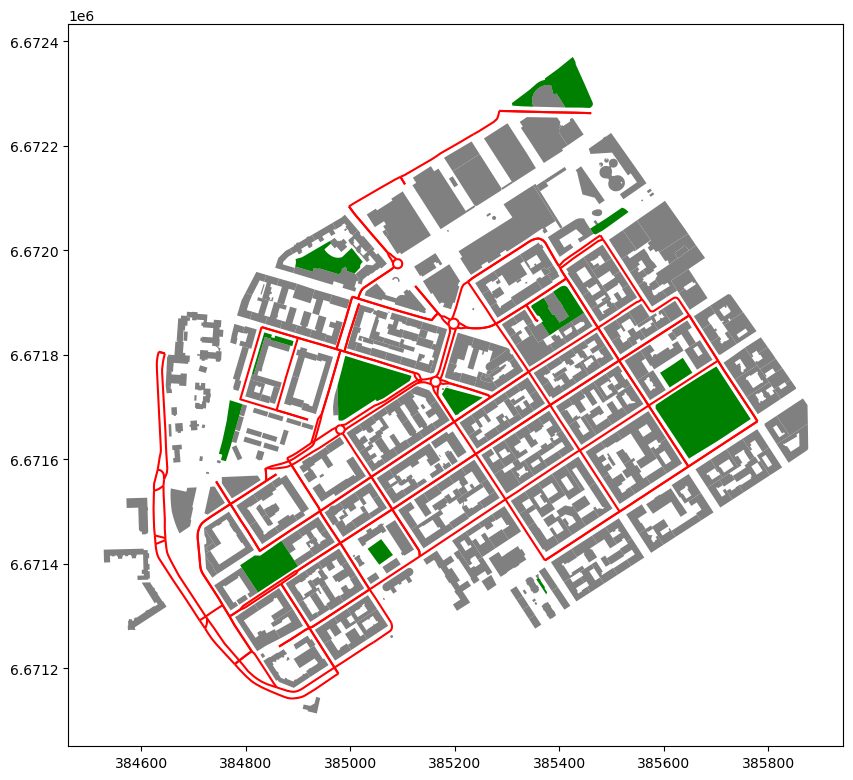

In [12]:
# Plot buildings, parks and roads
ax = buildings.plot(color="gray", figsize=(10,10))
ax = parks.plot(ax=ax, color="green")
ax = roads.plot(ax=ax, color="red")

_**Figure 6.46**. A map showing the buildings with gray color and the parks (green) in the neighborhood of Kamppi, Helsinki._

Similarly as finding the nearest neighbor using Points as input data, we can use the `.sjoin_nearest()` to find nearest neighbor between two Polygon datasets. Here, we find the nearest park for each building Polygon and store the distance into the column `distance`:

In [13]:
nearest_parks = buildings.sjoin_nearest(parks, distance_col="distance")
nearest_parks

osmid_left    building              name_left  \
0    11711721042         yes  Nice Bike Pyörähuolto   
1        8035238      public            Lasipalatsi   
2        8042297         yes     Radisson Blu Royal   
3       14797170      school                   None   
4       14797171         yes                   None   
..           ...         ...                    ...   
450      8092998         yes                   None   
451      8280536  apartments                   None   
452      8525159       civic                   None   
453      8525161       civic                   None   
454      8535506       civic                   None   

                                              geometry  index_right  \
0                       POINT (384966.661 6671503.786)           12   
1    POLYGON ((385459.650 6672184.469, 385456.356 6...            1   
2    POLYGON ((385104.154 6671916.693, 385101.584 6...            8   
3    POLYGON ((384815.326 6671762.710, 384815.792 6...            5   
4    POLYGON ((384797.759 6671853.253, 384798.253 6...            5   
..                                                 ...          ...   
450  POLYGON ((384747.465 6671811.996, 384744.270 6...            5   
451  POLYGON ((384839.007 6671934.815, 384839.485 6...            8   
452  POLYGON ((385495.275 6672164.009, 385494.928 6...            1   
453  POLYGON ((385486.225 6672173.653, 385486.717 6...            1   
454  POLYGON ((385481.130 6672167.861, 385482.372 6...            1   

     osmid_right leisure                name_right    distance  
0     1227991181    park  Kaartin lasaretin puisto  100.208527  
1        8042613    park            Simonpuistikko   16.284929  
2       37390082    park                      None   40.039501  
3       26999855    park                      None    0.000000  
4       26999855    park                      None   14.873403  
..           ...     ...                       ...         ...  
450     26999855    park                      None   70.819624  
451     37390082    park                      None   38.574646  
452      8042613    park            Simonpuistikko   32.792083  
453      8042613    park            Simonpuistikko   90.919207  
454      8042613    park            Simonpuistikko   87.821936  

[455 rows x 9 columns]

In [14]:
print("Maximum distance:", nearest_parks["distance"].max().round(0))
print("Average distance:", nearest_parks["distance"].mean().round(0))

Maximum distance: 229.0
Average distance: 61.0


Now we have found the nearest park for each building, and as we can see on average the closest park seem to be 61 meters away from the buildings while the longest distance from one of the buildings to the closest park seems to be 229 meters. In a simimar, manner we can also find the nearest road from each building as follows:

In [19]:
nearest_roads = buildings.sjoin_nearest(roads, distance_col="distance")
nearest_roads

osmid_left building              name_left  \
0    11711721042      yes  Nice Bike Pyörähuolto   
0    11711721042      yes  Nice Bike Pyörähuolto   
1        8035238   public            Lasipalatsi   
1        8035238   public            Lasipalatsi   
2        8042297      yes     Radisson Blu Royal   
..           ...      ...                    ...   
452      8525159    civic                   None   
453      8525161    civic                   None   
453      8525161    civic                   None   
454      8535506    civic                   None   
454      8535506    civic                   None   

                                              geometry  index_right  \
0                       POINT (384966.661 6671503.786)           24   
0                       POINT (384966.661 6671503.786)          182   
1    POLYGON ((385459.650 6672184.469, 385456.356 6...           15   
1    POLYGON ((385459.650 6672184.469, 385456.356 6...           33   
2    POLYGON ((385104.154 6671916.693, 385101.584 6...           83   
..                                                 ...          ...   
452  POLYGON ((385495.275 6672164.009, 385494.928 6...          107   
453  POLYGON ((385486.225 6672173.653, 385486.717 6...           15   
453  POLYGON ((385486.225 6672173.653, 385486.717 6...           33   
454  POLYGON ((385481.130 6672167.861, 385482.372 6...           15   
454  POLYGON ((385481.130 6672167.861, 385482.372 6...           33   

                                           osmid_right    name_right  \
0         [126894680, 126894676, 126894678, 126894679]   Eerikinkatu   
0         [126894680, 126894676, 126894678, 126894679]   Eerikinkatu   
1    [42574048, 42574049, 28920739, 77891210, 26999...  Arkadiankatu   
1    [42574048, 42574049, 28920739, 77891210, 26999...  Arkadiankatu   
2                        [37135576, 8035726, 37135575]   Salomonkatu   
..                                                 ...           ...   
452                                           51707742     Yrjönkatu   
453  [42574048, 42574049, 28920739, 77891210, 26999...  Arkadiankatu   
453  [42574048, 42574049, 28920739, 77891210, 26999...  Arkadiankatu   
454  [42574048, 42574049, 28920739, 77891210, 26999...  Arkadiankatu   
454  [42574048, 42574049, 28920739, 77891210, 26999...  Arkadiankatu   

         highway  index   distance  
0    residential     24  11.181066  
0    residential    182  11.181066  
1      secondary     15  52.015824  
1      secondary     33  52.015824  
2    residential     83   6.659959  
..           ...    ...        ...  
452  residential    107  88.553223  
453    secondary     15  90.569914  
453    secondary     33  90.569914  
454    secondary     15  96.128437  
454    secondary     33  96.128437  

[703 rows x 10 columns]

As a result, we now have found the nearest road for each building. We have now 703 rows of data which means that for some buildings there have been more than one road that are exactly the same distance apart. To better understand how the spatial join between the buildings and roads have been conducted, we can again visualize the nearest neighbors with a straight line. To do this, we first bring the geometries from the `roads` GeoDataFrame into the same table with the buildings: 

In [20]:
roads["index"] = roads.index
nearest_roads = nearest_roads.merge(roads[["geometry", "index"]], left_on="index_right", right_on="index")
nearest_roads.head(3)

osmid_left building              name_left  \
0  11711721042      yes  Nice Bike Pyörähuolto   
1  11711721042      yes  Nice Bike Pyörähuolto   
2      8035238   public            Lasipalatsi   

                                          geometry_x  index_right  \
0                     POINT (384966.661 6671503.786)           24   
1                     POINT (384966.661 6671503.786)          182   
2  POLYGON ((385459.650 6672184.469, 385456.356 6...           15   

                                         osmid_right    name_right  \
0       [126894680, 126894676, 126894678, 126894679]   Eerikinkatu   
1       [126894680, 126894676, 126894678, 126894679]   Eerikinkatu   
2  [42574048, 42574049, 28920739, 77891210, 26999...  Arkadiankatu   

       highway  index_x   distance  \
0  residential       24  11.181066   
1  residential      182  11.181066   
2    secondary       15  52.015824   

                                          geometry_y  index_y  
0  LINESTRING (384942.149 6671500.856, 384950.743...       24  
1  LINESTRING (385040.141 6671566.384, 385034.832...      182  
2  LINESTRING (385285.226 6672266.801, 385296.799...       15

Now we have the `geometry_x` column representing the building geometries and the `geometry_y` column representing the road geometries (LineStrings). To visualize the connecting lines between buildings and roads, we first need to create geometries that connect the building and closest road geometry from the locations where the distance is shortest. To do this, we can take advantage of a handy function called `nearest_points()` from the `shapely` library that returns a list of Point objects representing the locations with shortest distance between geometries. By using these points as input, we can create a LineString geometries that represent the connector between a given building and the closest road. Finally, we create a new GeoDataFrame called `connectors` out of these lines and also store the length of the LineStrings as a separate column:

In [21]:
from shapely.ops import nearest_points

# Generate LineString between nearest points of two geometries
connectors = nearest_roads.apply(lambda row: LineString(nearest_points(row["geometry_x"], row["geometry_y"])), axis=1)

# Create a new GeoDataFrame out of these geometries 
connectors = gpd.GeoDataFrame({"geometry": connectors}, crs=roads.crs)
connectors["distance"] = connectors.length
connectors.head()

geometry   distance
0  LINESTRING (384966.661 6671503.786, 384960.444...  11.181066
1  LINESTRING (384966.661 6671503.786, 384960.444...  11.181066
2  LINESTRING (385487.966 6672217.975, 385460.972...  52.015824
3  LINESTRING (385487.966 6672217.975, 385460.972...  52.015824
4  LINESTRING (385050.507 6671936.920, 385046.795...   6.659959

Great, now we have a new GeoDataFrame that represents the connectors between the buildings and the drivable roads. Finally, we can visualize the buildings, roads and these connectors to better understand the exact points where the distance between a given building and the closest road is shortest:

In [22]:
m = buildings.explore(color="gray", tiles="CartoDB Positron")
m = roads.explore(m=m, color="red")
m = connectors.explore(m=m, color="green")
m

_**Figure 6.47**. A map showing the closest road for each building. The LineStrings marked with green color show the exact location where the distance between a given building and the road is shortest._

## K-Nearest Neighbor search

Thus far, we have only focused on finding the nearest neighbor to a given geometry. However, quite commonly you might want to find not only the closest geometry, but a specific number of closest geometries to a given location (1st closest, 2nd closest, and so on). For example, you might be interested to find 3-5 closest public transport stops from your home, because these stops might provide alternative connections to different parts of the city. Doing these kind of queries is a common procedure and a prerequisite for many data analysis techniques, and the technique is commonly called as *{term}`K-Nearest Neighbors search`* (or KNN search). Next, we will learn how to find *k* number of closest neighbors based on two GeoDataFrames. We will first aim to find the three nearest public transport stops for each building in the Helsinki Region, and then we will see how to make a *{term}`radius query`* to find all neighbors within specific distance apart from a given location. K-Nearest Neighbor search techniques are also typically built on top of *{term}`spatial indices <spatial index>`* to make the queries more efficient. Previously, with `sjoin_nearest()`, we used an `R-tree` index structure to efficiently find the nearest neighbor for any kind of geometry. However, because the R-tree implementation in Python only supports finding the closest neighbor (a limitation in the underlying GEOS software), we need to use another tree structure called *{term}`KD-Tree`* (K-dimensional tree) that can provide us information about K-nearest neighbors (i.e. not only the closest). KD-tree is similar to R-tree, but the data is ordered and sorted in a bit different manner (see Appendices for further details). 

In Python, we can conduct KNN search between Point datasets using the `scipy` library. Before we can do the actual query, we need to build the `KD-Tree` spatial index. In scipy, we can use the `KDTree` to build the spatial index which is available from the `scipy.spatial` submodule. The `KDTree` has been implemented in C-language which makes it very fast. In the following, we use the `building_points` and `stops` GeoDataFrames that we already used earlier to find three closest public transport stops for each building. Let's start by reading the data and reproject the GeoDataFrames into a metric coordinate reference system (EPSG:3067) so that the distances will be presented as meters:

In [2]:
import geopandas as gpd

# Read the files and reproject to EPSG:3067
stops = gpd.read_file("data/Helsinki/pt_stops_helsinki.gpkg").to_crs(epsg=3067)
building_points = gpd.read_file("data/Helsinki/building_points_helsinki.zip").to_crs(epsg=3067)

building_points.head(2)

name                        geometry
0         None  POINT (381166.600 6676424.438)
1  Uimastadion  POINT (385236.565 6674238.472)

In [3]:
stops.head(2)

stop_name  stop_lat  stop_lon  stop_id                        geometry
0  Ritarihuone  60.16946  24.95667  1010102  POINT (386623.301 6672037.884)
1   Kirkkokatu  60.17127  24.95657  1010103  POINT (386623.991 6672239.572)

In [9]:
stops.shape

(8377, 5)

As we see, both datasets include Point geometries representing specific buildings and public transport stops (n=8377). 

As a first step, we need to build a `KDTRee` index structure based on the Point coordinates. The `KDTree` class expects the Point coordinates to be in `array` format, i.e. not as shapely `Point` objects which we have stored in the `geometry` column. Luckily, it is very easy to convert the shapely geometries into `numpy.array` format by chaining a method `.get_coordinates()` with the `.to_numpy()` method as follows: 

In [7]:
building_coords = building_points.get_coordinates().to_numpy()
stop_coords = stops.geometry.get_coordinates().to_numpy()

stop_coords

array([[ 386623.30055697, 6672037.88387716],
       [ 386623.99053928, 6672239.57164472],
       [ 386629.00011373, 6672130.5382358 ],
       ...,
       [ 393706.51571504, 6707260.21305267],
       [ 391372.74617002, 6697807.78260742],
       [ 388733.41604041, 6714694.15542812]])

By running these commands, the `.get_coordinates()` method first returns a DataFrame with `x` and `y` coordinates as columns, and the `.to_numpy()` method then converts this data into a numpy `array` as we see above. The `stop_coords` variable now contains an array of coordinate tuples (x and y coordinates) which we can pass to the `KDTree` class and create a KD-Tree index structure as follows: 

In [8]:
from scipy.spatial import KDTree

stop_kdt = KDTree(stop_coords)
stop_kdt

Now we have initialized a `KDTree` index structure by populating it with stop coordinates. By doing this, we can make very fast queries and find out which of the approx. 8000 stops is closest to specific buildings. To do this, we can use the `.query()` method which goes through all the input coordinates (i.e. buildings) and very quickly calculates which of them is the closest, 2nd closest etc. The method returns the distances to the K-number of nearest neighbors as well as the index of the closest `stop` to the given building. By passing an argument `k=3`, we can specify that we want to find three closest neighbors for each building: 

In [15]:
# Find the three nearest neighbors from stop KD-Tree for each building
k_nearest_dist, k_nearest_ix = stop_kdt.query(building_coords, k=3)

len(k_nearest_dist)

158731

The `stop_kdt.query()` call returns us two objects. The first one which we store to variable `k_nearest_dist` represents an array/list of distances from each building (n=158 731) to the three of the closest public transport stops in the data. The second variable `k_nearest_ix` represents the index values of the three nearest stops for each building: 

In [13]:
# Distances to 3 nearest stops
k_nearest_dist

array([[ 92.67989301, 461.43820422, 466.16915044],
       [400.24336963, 409.49707253, 410.06137016],
       [109.81963349, 130.59749777, 133.6424814 ],
       ...,
       [135.34174505, 136.28586705, 274.93549394],
       [ 99.40810774, 118.1492825 , 209.42172325],
       [ 67.79042163,  71.91370036, 103.08138812]])

In [14]:
# Index values of the 3 nearest stops
k_nearest_ix

array([[1131, 1135, 1125],
       [ 467,  465,  475],
       [  61,   64,   13],
       ...,
       [4655, 4678, 4614],
       [4624, 4625, 4680],
       [4665, 4617, 4619]])

Based on these arrays, we can see that the closest stop to the first building in our data is 92.7 meters away from the building, while the second and third closest stops are approximately 460 meters away from the given building. By looking at the index values in the `k_nearest_ix` variable, we can see that the stops with indices 1131, 1135 and 1125 seem to be the three closest public transport stops to the first building in our data. 

Now we have successfully computed the K-nearest neighbors between the buildings and the stops. Next, we will attach this information back to our GeoDataFrame so that it is easier to do further analyses with the data and create some nice maps out of the data. The data which is returned by the `stop_kdt.query()` command comes out as an array of lists, where each item (list) contains three values that show the distances between three nearest stops and the given building. To be able to easily merge this data with the original GeoDataFrame containing the building data, we need to transpose our arrays. After the transpose, the data will be restructured in a way that there will be three arrays and each of these arrays contains the distances/stop-ids for all the buildings in a single list. To transpose a numpy array, we can use the method `.T` which does the trick:

In [16]:
k_nearest_ix.T

array([[1131,  467,   61, ..., 4655, 4624, 4665],
       [1135,  465,   64, ..., 4678, 4625, 4617],
       [1125,  475,   13, ..., 4614, 4680, 4619]])

By following this approach, we can store the index and distance information as columns into our GeoDataFrame containing values for the 1-3 nearest stops. In the following, we first create a clean copy of the `building_points` GeoDataFrame into variable `k_nearest`, which we will then populate with three new columns for the stop indices, and three columns for the distances to the 1-3 closest stops. To access the information for the closest stop, we can call `.T[0]`, while the `.T[1]` and `.T[2]` returns the information for the second and third closest stops accordingly:

In [17]:
# Make a copy
k_nearest = building_points.copy()

# Add indices of nearest stops
k_nearest["1st_nearest_idx"] = k_nearest_ix.T[0]
k_nearest["2nd_nearest_idx"] = k_nearest_ix.T[1]
k_nearest["3rd_nearest_idx"] = k_nearest_ix.T[2]

# Add distances 
k_nearest["1st_nearest_dist"] = k_nearest_dist.T[0]
k_nearest["2nd_nearest_dist"] = k_nearest_dist.T[1]
k_nearest["3rd_nearest_dist"] = k_nearest_dist.T[2]

In [18]:
k_nearest.head()

name                        geometry  1st_nearest_idx  \
0            None  POINT (381166.600 6676424.438)             1131   
1     Uimastadion  POINT (385236.565 6674238.472)              467   
2            None  POINT (386317.478 6672100.648)               61   
3  Hartwall Arena  POINT (385225.109 6676120.560)              532   
4           Talli  POINT (385079.733 6676989.745)              496   

   2nd_nearest_idx  3rd_nearest_idx  1st_nearest_dist  2nd_nearest_dist  \
0             1135             1125         92.679893        461.438204   
1              465              475        400.243370        409.497073   
2               64               13        109.819633        130.597498   
3              533              506        104.632434        137.706391   
4              497              498        472.248282        519.685534   

   3rd_nearest_dist  
0        466.169150  
1        410.061370  
2        133.642481  
3        377.331985  
4        551.358778

Perfect! Now we have stored the information for each building about the indices and distances to the three of the closest stops around given buildings. To make this information easier to understand, we can make a nice map that shows the closest three stops for each building. To do this, we can follow a similar approach as we used earlier when visualizing the results from the `sjoin_nearest()` function. Namely, we bring the geometry from the k-nearest stops and connect the building Points with the given stop Points with a LineString. Then it is easy to visualize the closest stops for each building. In the following, we create three separate GeoDataFrames that correspond to the nearest, second nearest and third nearest stops from the buildings. We start by storing the `stop_index` as a column which allows us to easily merge the data between `stops` and `k_nearest` (buildings) GeoDataFrames. For making the table join, we can use the pandas `.merge()` function in which we use the `1st_nearest_idx`,  `2nd_nearest_idx` and `3rd_nearest_idx` as the key on the left GeoDataFrame, while the `stop_index` is the key on the right GeoDataFrame. We also pass the `suffixes=('', '_knearest)` argument to the `.merge()` method to specify that the column names on the left-side GeoDataFrame should stay as they are, while the column names on the right-side will get a suffix `_knearest` in case there are identical column names present in both GeoDataFrames (which we have as both frames contain the `geometry` column. Let's see how we can create these three GeoDataFrames stored into `k_nearest_1`, `k_nearest_2` and `k_nearest_3` variables:

In [22]:
# Store the stop index for making the table join
stops["stop_index"] = stops.index

In [23]:
# Merge the geometries of the nearest stops to the GeoDataFrame
k_nearest_1 = k_nearest.merge(stops[["stop_index", "geometry"]], left_on="1st_nearest_idx", right_on="stop_index", suffixes=('', '_knearest'))
k_nearest_1.head(2)

name                        geometry  1st_nearest_idx  \
0         None  POINT (381166.600 6676424.438)             1131   
1  Uimastadion  POINT (385236.565 6674238.472)              467   

   2nd_nearest_idx  3rd_nearest_idx  1st_nearest_dist  2nd_nearest_dist  \
0             1135             1125         92.679893        461.438204   
1              465              475        400.243370        409.497073   

   3rd_nearest_dist  stop_index               geometry_knearest  
0         466.16915        1131  POINT (381256.660 6676446.317)  
1         410.06137         467  POINT (384973.331 6674539.973)

In [24]:
# Merge the geometries of the 2nd nearest stops to the GeoDataFrame
k_nearest_2 = k_nearest.merge(stops[["stop_index", "geometry"]], left_on="2nd_nearest_idx", right_on="stop_index", suffixes=('', '_knearest'))
k_nearest_2.head(2)

name                        geometry  1st_nearest_idx  \
0         None  POINT (381166.600 6676424.438)             1131   
1  Uimastadion  POINT (385236.565 6674238.472)              467   

   2nd_nearest_idx  3rd_nearest_idx  1st_nearest_dist  2nd_nearest_dist  \
0             1135             1125         92.679893        461.438204   
1              465              475        400.243370        409.497073   

   3rd_nearest_dist  stop_index               geometry_knearest  
0         466.16915        1135  POINT (381625.316 6676474.488)  
1         410.06137         465  POINT (385270.775 6674646.538)

In [25]:
# Merge the geometries of the 3rd nearest stops to the GeoDataFrame
k_nearest_3 = k_nearest.merge(stops[["stop_index", "geometry"]], left_on="3rd_nearest_idx", right_on="stop_index", suffixes=('', '_knearest'))
k_nearest_3.head(2)

name                        geometry  1st_nearest_idx  \
0         None  POINT (381166.600 6676424.438)             1131   
1  Uimastadion  POINT (385236.565 6674238.472)              467   

   2nd_nearest_idx  3rd_nearest_idx  1st_nearest_dist  2nd_nearest_dist  \
0             1135             1125         92.679893        461.438204   
1              465              475        400.243370        409.497073   

   3rd_nearest_dist  stop_index               geometry_knearest  
0         466.16915        1125  POINT (381632.740 6676429.668)  
1         410.06137         475  POINT (385122.170 6674632.254)

**ADD TEXT**

In [26]:
from shapely import LineString

# Generate LineStrings connecting the building point and K-nearest neighbor
k_nearest_1["geometry"] = k_nearest_1.apply(lambda row: LineString([ row["geometry"], row["geometry_knearest"] ]), axis=1)
k_nearest_2["geometry"] = k_nearest_2.apply(lambda row: LineString([ row["geometry"], row["geometry_knearest"] ]), axis=1)
k_nearest_3["geometry"] = k_nearest_3.apply(lambda row: LineString([ row["geometry"], row["geometry_knearest"] ]), axis=1)

**ADD TEXT**

In [27]:
# Find unique building names
k_nearest.name.unique()

array([None, 'Uimastadion', 'Hartwall Arena', ..., 'Peltolan koulu',
       'Hilton Helsinki Airport', 'Posti Oy Logistiikkakeskus'],
      dtype=object)

**ADD TEXT**

In [28]:
# Visualize 3 nearest stops to
selected_name = "Hartwall Arena"

m = k_nearest_1.loc[k_nearest_1["name"]==selected_name].explore(color="red", tiles="CartoDB Positron", max_zoom=16)
m = k_nearest_2.loc[k_nearest_2["name"]==selected_name].explore(m=m, color="orange")
m = k_nearest_3.loc[k_nearest_3["name"]==selected_name].explore(m=m, color="blue")
m = stops.explore(m=m, color="green")
m

**ADD TEXT**

## Range search

In [39]:
building_kdt = cKDTree(building_coords)

# Find the three nearest neighbors from stop KD-Tree for each building
k_nearest_ix = stop_kdt.query_ball_tree(building_kdt, r=200)

In [40]:
len(k_nearest_ix)

8377

In [41]:
k_nearest_ix[0]

[1129,
 1130,
 1155,
 2054,
 2055,
 2056,
 2057,
 2058,
 2059,
 9910,
 9955,
 9956,
 9957,
 10993,
 25983,
 25984,
 25985,
 25986,
 26029,
 26030,
 26031,
 26032,
 26033,
 28253,
 35395,
 35397,
 35400,
 35401,
 35418,
 35420,
 35421,
 35460,
 48124,
 48284,
 48285,
 49383,
 58133,
 58181,
 58182,
 58201,
 58203,
 58204,
 58208,
 58209,
 58210,
 58211,
 58212,
 58318,
 58320,
 58378]

In [42]:
stops.head()

stop_name   stop_lat   stop_lon  stop_id                        geometry  \
0  Ritarihuone  60.169460  24.956670  1010102  POINT (386623.301 6672037.884)   
1   Kirkkokatu  60.171270  24.956570  1010103  POINT (386623.991 6672239.572)   
2   Kirkkokatu  60.170293  24.956721  1010104  POINT (386629.000 6672130.538)   
3    Vironkatu  60.172580  24.956554  1010105  POINT (386627.617 6672385.448)   
4    Vironkatu  60.172990  24.956380  1010106  POINT (386619.379 6672431.394)   

   stop_index  
0           0  
1           1  
2           2  
3           3  
4           4

In [43]:
stops["building_ids_within_range"] = k_nearest_ix

In [44]:
stops.head()

stop_name   stop_lat   stop_lon  stop_id                        geometry  \
0  Ritarihuone  60.169460  24.956670  1010102  POINT (386623.301 6672037.884)   
1   Kirkkokatu  60.171270  24.956570  1010103  POINT (386623.991 6672239.572)   
2   Kirkkokatu  60.170293  24.956721  1010104  POINT (386629.000 6672130.538)   
3    Vironkatu  60.172580  24.956554  1010105  POINT (386627.617 6672385.448)   
4    Vironkatu  60.172990  24.956380  1010106  POINT (386619.379 6672431.394)   

   stop_index                          building_ids_within_range  
0           0  [1129, 1130, 1155, 2054, 2055, 2056, 2057, 205...  
1           1  [1130, 2054, 2055, 2057, 2058, 2059, 2066, 206...  
2           2  [1129, 1130, 2054, 2055, 2056, 2057, 2058, 205...  
3           3  [2060, 2062, 2063, 2064, 2065, 2066, 2067, 206...  
4           4  [1136, 2060, 2061, 2062, 2063, 2064, 2065, 206...

In [45]:
stops["building_cnt"] = stops["building_ids_within_range"].apply(lambda id_list: len(id_list))

In [46]:
stops.head()

stop_name   stop_lat   stop_lon  stop_id                        geometry  \
0  Ritarihuone  60.169460  24.956670  1010102  POINT (386623.301 6672037.884)   
1   Kirkkokatu  60.171270  24.956570  1010103  POINT (386623.991 6672239.572)   
2   Kirkkokatu  60.170293  24.956721  1010104  POINT (386629.000 6672130.538)   
3    Vironkatu  60.172580  24.956554  1010105  POINT (386627.617 6672385.448)   
4    Vironkatu  60.172990  24.956380  1010106  POINT (386619.379 6672431.394)   

   stop_index                          building_ids_within_range  building_cnt  
0           0  [1129, 1130, 1155, 2054, 2055, 2056, 2057, 205...            50  
1           1  [1130, 2054, 2055, 2057, 2058, 2059, 2066, 206...            69  
2           2  [1129, 1130, 2054, 2055, 2056, 2057, 2058, 205...            56  
3           3  [2060, 2062, 2063, 2064, 2065, 2066, 2067, 206...            74  
4           4  [1136, 2060, 2061, 2062, 2063, 2064, 2065, 206...            78

In [47]:
print("Max number of buildings:", stops["building_cnt"].max())
print("Average number of buildings:", stops["building_cnt"].mean().round(1))

Max number of buildings: 181
Average number of buildings: 32.2


In [48]:
stops.loc[stops["building_cnt"] == stops["building_cnt"].max()].explore(tiles="CartoDB Positron", color="red", marker_kwds={"radius": 5}, max_zoom=16)

There is an alternative approach for making a radius query by calculating a buffer around the stop points and then making a spatial join between these Polygon geometries and the buildings. This approach also allows to make queries between other type of geometries than Points. 